In [1]:
import scipy.io
from scipy import interpolate, signal
from scipy.signal import hilbert, chirp, decimate, convolve2d 
from scipy.stats import zscore

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import struct

import nelpy as nel
import nelpy.io
import nelpy.plotting as npl

import numpy as np

npl.setup()


In [527]:
import matplotlib

# this will help your plots have larger font, which is more visually appealing
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)

In [452]:
lfp = np.load("Data/Depth1_67_2_to_3mins.npy")
raise_electrodes = np.load("Data/Raise_Electrodes_3_to_4mins.npy")

In [47]:
colors = ['#00CF97','#F05340','#56B4E9','#D3AA65','#B47CC7','#C44E52']


In [58]:
# print(np.mean(lfp[1]))
# print(np.mean(lfp[2]))
# print(np.mean(lfp[3]))

In [48]:
time = lfp[0]
fs = 30000 # kHz

start = time[0]
stop = time[-1]

session_bounds = nel.EpochArray([start, stop])
session_bounds

<EpochArray at 0x7fb4d444a0d0: 1 epoch> of length 46.5237 seconds

In [60]:
len(time)/fs

46.52373333333333

In [5]:
t_start = 100
time_duration = 10 # seconds
snip_start = np.where(time >= t_start)[0][0]
snip_end = snip_start + time_duration*fs

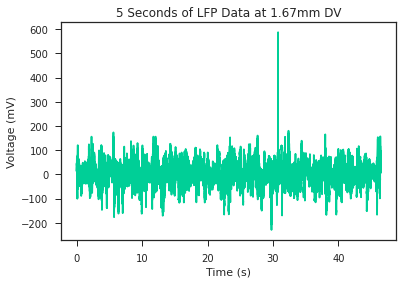

In [62]:
# t = time[snip_start:snip_end]
# snip = lfp[1][snip_start:snip_end]

t = time - np.min(time)
snip = lfp[1]

plt.plot(t,snip) 
plt.title("5 Seconds of LFP Data at 1.67mm DV") 
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.show()


## Compare with Notch Filter

In [7]:
asa = nel.AnalogSignalArray(data=snip,time=t) 

# NOTCH FILTER 

f0 = 60 #remove freq
Q = 10 #Quality factor
w0 = f0/(fs/2) #normalized freq
#design notch filter
b, a = signal.iirnotch(w0,Q)
# Frequency response
w, h = signal.freqz(b, a)
# Generate frequency axis
freq = w*fs/(2*np.pi)

asa._ydata = signal.filtfilt(b,a,asa.ydata) #60 hz notch filter


def make_snippet(time, data, t_start=0, time_duration=1):
    snip_start = np.where(time >= t_start)[0][0]
    snip_end = snip_start + time_duration*fs
    
    t = time[snip_start:snip_end]
    snip = data[snip_start:snip_end]
    
    return t, snip

def make_asa(t,data):
    return nel.AnalogSignalArray(data=snip,time=t) 

def notch_filter(asa):
    f0 = 60 #remove freq
    Q = 10 #Quality factor
    w0 = f0/(fs/2) #normalized freq
    #design notch filter
    b, a = signal.iirnotch(w0,Q)
    # Frequency response
    w, h = signal.freqz(b, a)
    # Generate frequency axis
    freq = w*fs/(2*np.pi)

    asa._ydata = signal.filtfilt(b,a,asa.ydata) #60 hz notch filter
    
    return asa


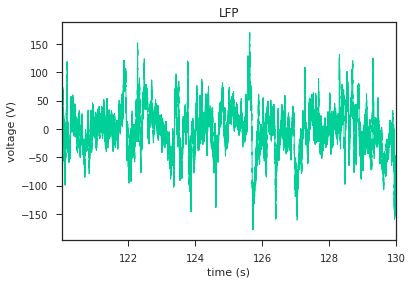

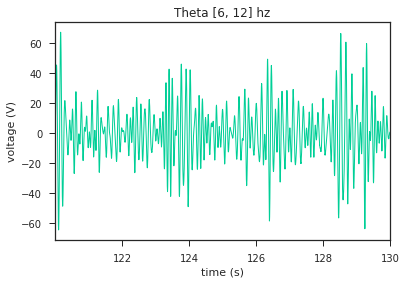

In [8]:
theta = [6, 12]
delta = [1, 4]
spike_band = [300, 6000]
gamma = [32, 100]
theta_data = nel.filtering.sosfiltfilt(asa,fl=theta[0],fh=theta[1],) 

# spike  600--6000
    # ripple 150--250
    # delta 1--4
    # theta 6--12
    # gamma 32--100
    
plt.figure()
npl.plot(asa, lw=1) 
plt.title('LFP') 
plt.show()

plt.figure()
npl.plot(theta_data, lw=1) 
plt.title('Theta ' + str(theta) + " hz") 
plt.show()

# data = nel.filtering.sosfiltfilt(asa,fl=delta[0],fh=delta[1],) 
# plt.figure()
# npl.plot(data, lw=1) 
# plt.title('Delta ' + str(delta) + " hz") 
# plt.show()

# data = nel.filtering.sosfiltfilt(asa,fl=gamma[0],fh=gamma[1],) 
# plt.figure()
# npl.plot(data, lw=1, color='k') 
# plt.title('Gamma ' + str(gamma) + " hz") 
# plt.show()

# data = nel.filtering.sosfiltfilt(asa,fl=spike_band[0],fh=spike_band[1],) 
# plt.figure()
# npl.plot(data, lw=1) 
# plt.title('Spike Band ' + str(spike_band) + " hz") 
# plt.show()

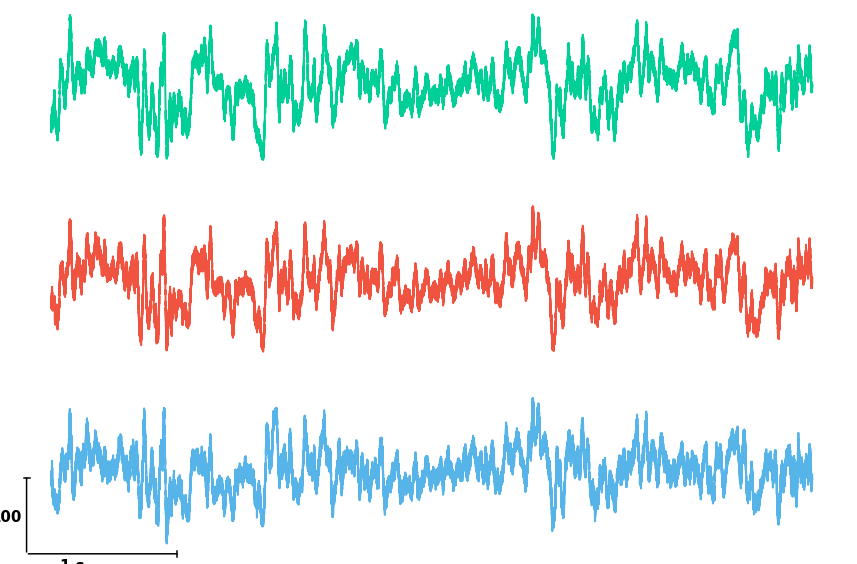

In [571]:
three_electrodes = []
for i in range(3):
    t, snip = make_snippet(time=lfp[0], data=lfp[i+1], t_start=135, time_duration=5)
    asa = make_asa(t,data=snip)
    asa = notch_filter(asa)
    three_electrodes.append(asa)
    
n_traces = 3

fig, axes = plt.subplots(n_traces, 1, figsize=(15, 10))
i = 0
for ax in axes:
    plot_data = three_electrodes[i].ydata[0]

    ax.plot(plot_data, color=colors[i],linewidth=2)    
    i += 1
    
npl.utils.clear_left_right(*axes)
npl.utils.clear_top_bottom(*axes)
npl.scalebar.add_scalebar(ax=axes[2], sizex=1*fs, sizey=100, labely='100', labelx='1 s', pad=-2, loc="lower left")


plt.savefig("three-electrodes-LFP-3-colors.png", dpi=300)

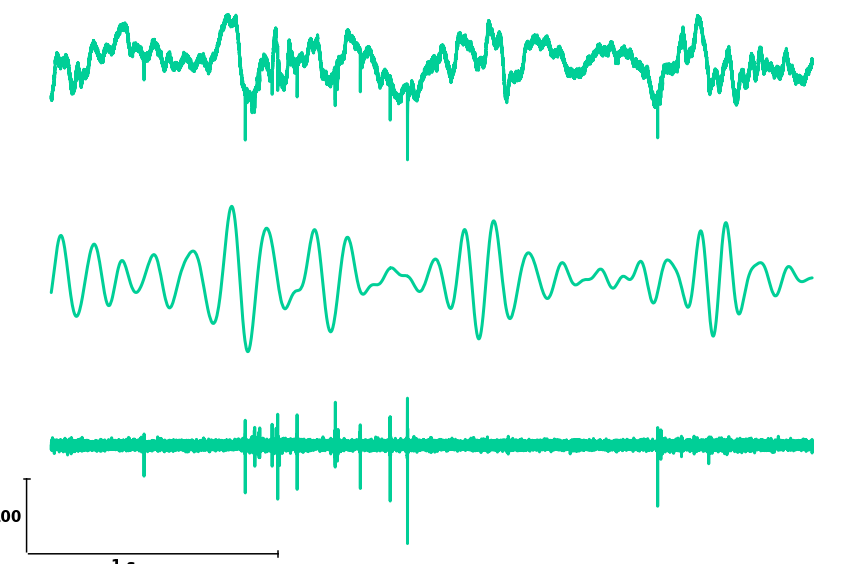

In [565]:

three_electrodes_raise = []
for i in range(3):
    t, snip = make_snippet(time=raise_electrodes[0], data=raise_electrodes[i+1], t_start=196, time_duration=3)
    asa = make_asa(t,data=snip)
    asa = notch_filter(asa)
    three_electrodes_raise.append(asa)
    
lfp_data = three_electrodes_raise[0].ydata[0]
theta_data = nel.filtering.sosfiltfilt(three_electrodes_raise[0],fl=theta[0],fh=theta[1],).ydata[0]
spike_data = nel.filtering.sosfiltfilt(three_electrodes_raise[0],fl=spike_band[0],fh=spike_band[1],).ydata[0]

plot_data = []
plot_data.append(lfp_data)
plot_data.append(theta_data)
plot_data.append(spike_data)

colors = ['#00CF97','#F05340','#56B4E9','#D3AA65','#B47CC7','#C44E52']
           

n_traces = 3
fig, axes = plt.subplots(n_traces, 1, figsize=(15, 10))
i = 0

for ax in axes:
    ax.plot(plot_data[i], color=colors[0],linewidth=3)    
    i += 1
    
npl.utils.clear_left_right(*axes)
npl.utils.clear_top_bottom(*axes)

# scalebar = ScaleBar(1, "m", location="lower right", height_fraction=0.02)  # Adjust height_fraction
# plt.add_artist(scalebar)

# npl.scalebar.add_scalebar(ax=axes[2], sizex=1*fs, sizey=100, labely='100', labelx='1 s', pad=-1, loc="lower left")
npl.scalebar.add_scalebar(ax=axes[2], sizex=1*fs, sizey=100, labely='100', labelx='1 s', pad=-2, loc="lower left")

plt.savefig("LFP-Theta-SpikeBand-One-Color.png", dpi=300)

<AxesSubplot:>

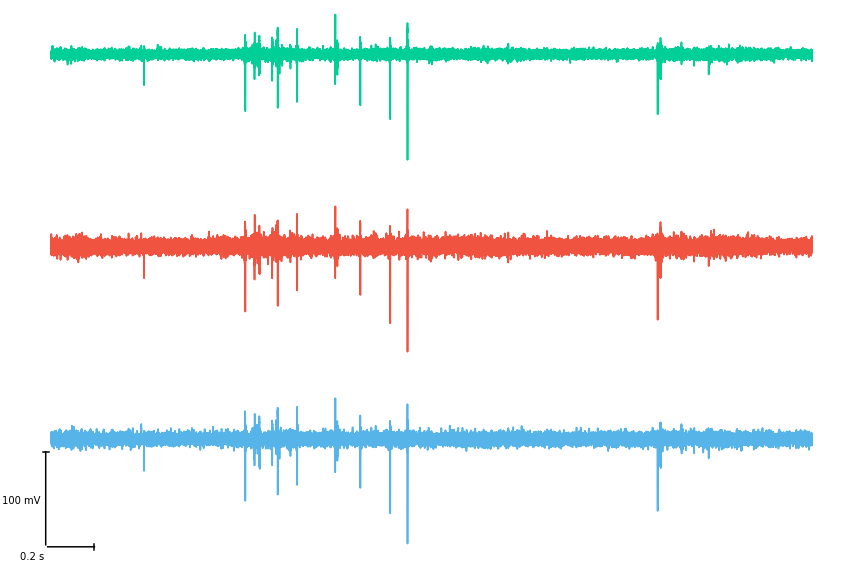

In [15]:

# Compare High Frequency Activity Among 3 Electrodes

spike_data1 = nel.filtering.sosfiltfilt(three_electrodes_raise[0],fl=spike_band[0],fh=spike_band[1],).ydata[0]
spike_data2 = nel.filtering.sosfiltfilt(three_electrodes_raise[1],fl=spike_band[0],fh=spike_band[1],).ydata[0]
spike_data3 = nel.filtering.sosfiltfilt(three_electrodes_raise[2],fl=spike_band[0],fh=spike_band[1],).ydata[0]

mean_signal = np.mean([spike_data1,spike_data2,spike_data3],axis=0)

plot_data = []

# plot_data.append(spike_data1-spike_data1)
# plot_data.append(spike_data2-spike_data1)
# plot_data.append(spike_data3-spike_data1)

# plot_data.append(spike_data1-mean_signal)
# plot_data.append(spike_data2-mean_signal)
# plot_data.append(spike_data3-mean_signal)
plot_data.append(spike_data1)
plot_data.append(spike_data2)
plot_data.append(spike_data3)

colors = ['#00CF97','#F05340','#56B4E9','#D3AA65','#B47CC7','#C44E52']
           

n_traces = 3
fig, axes = plt.subplots(n_traces, 1, figsize=(15, 10))
i = 0

for ax in axes:
    ax.plot(plot_data[i], color=colors[i])    
    i += 1
    
npl.utils.clear_left_right(*axes)
npl.utils.clear_top_bottom(*axes)
npl.scalebar.add_scalebar(ax=axes[2], sizex=1*fs/5, sizey=100, labely='100 mV', labelx='0.2 s', pad=-1, loc="lower left")


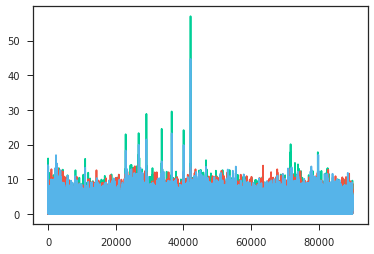

In [16]:
plt.plot(np.abs(plot_data[1] - plot_data[0]))
plt.plot(np.abs(plot_data[1] - plot_data[2]))
plt.plot(np.abs(plot_data[2] - plot_data[0]))

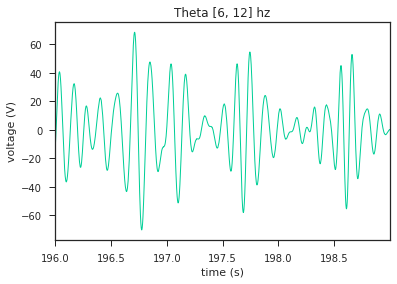

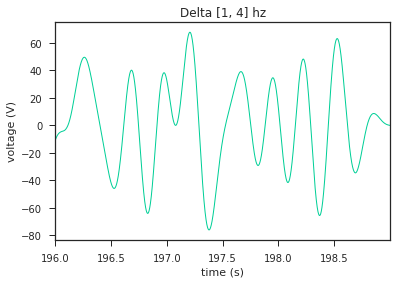

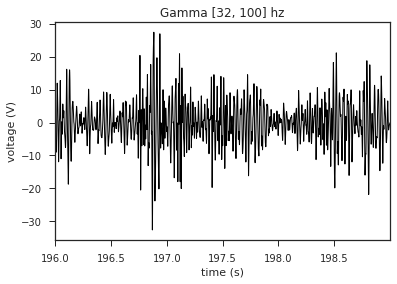

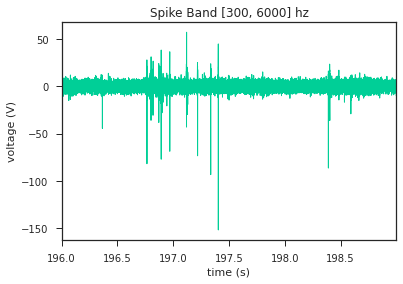

In [21]:
asa = three_electrodes_raise[0]

theta_data = nel.filtering.sosfiltfilt(asa,fl=theta[0],fh=theta[1],) 
plt.figure()
npl.plot(theta_data, lw=1) 
plt.title('Theta ' + str(theta) + " hz") 
plt.show()

data = nel.filtering.sosfiltfilt(asa,fl=delta[0],fh=delta[1],) 
plt.figure()
npl.plot(data, lw=1) 
plt.title('Delta ' + str(delta) + " hz") 
plt.show()

data = nel.filtering.sosfiltfilt(asa,fl=gamma[0],fh=gamma[1],) 
plt.figure()
npl.plot(data, lw=1, color='k') 
plt.title('Gamma ' + str(gamma) + " hz") 
plt.show()

data = nel.filtering.sosfiltfilt(asa,fl=spike_band[0],fh=spike_band[1],) 
plt.figure()
npl.plot(data, lw=1) 
plt.title('Spike Band ' + str(spike_band) + " hz") 
plt.show()

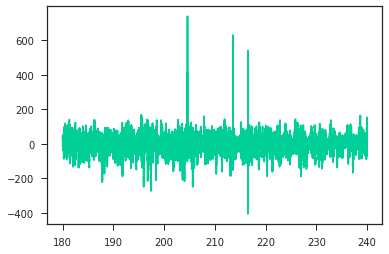

In [22]:
plt.plot(raise_electrodes[0], raise_electrodes[1])

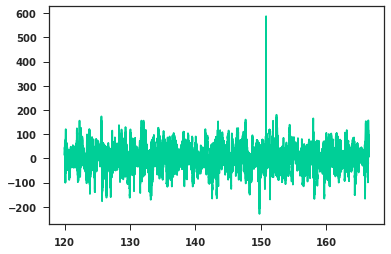

In [376]:
plt.plot(lfp[0], lfp[1])

In [377]:
raise_electrodes[1]

array([15.405, 16.575, 15.6  , ..., 61.62 , 64.35 , 69.42 ])

In [479]:
def filter_timestamps(timestamps, threshold=25):
    selected = []
    for i in range(len(timestamps)):
        if (i == 0 or abs(timestamps[i] - timestamps[i-1]) >= threshold):
            selected.append(timestamps[i])
    return np.array(selected)

def detectSpikes(data, time, threshold, Fs, isi=25):
    """
    Function to detect spikes in an electrophysiology trace by finding times when data amplitude (absolute value) exceeds a threshold.
    inputs: data - vector time-series of voltage input ([1 x time] or [time x 1])
            threshold - scalar threshold value for spike detection (units same as data)
            Fs        - sampling rate (samples/second) of 'data' vector
    outputs: spike_times - vector ([# spikes x 1]) of times (in seconds) of detected spikes
            spike_waveforms - matrix ([# spikes x 30]) of waveform of each detected spike.
    """
    num_waveform_points_total = 100 # # of samples to load to capture the waveforms
    num_waveform_points_before = 30 # # of samples before detection point to load


    if threshold > 0:
        amp_above_threshold = data > threshold
    else:
        amp_above_threshold = data < threshold

    #2. create a vector that = 1 when amp_above_threshold goes from 0 -> 1 (hint: can be done in one line)
    Low_hi = amp_above_threshold*1

    # 3. get the time index when low_hi = 1 (i.e. when our signal goes from below to above the threshold)
    # this corresponds to the index of detected spikes
    spike_idx =  np.where(Low_hi == 1)[0]
    spike_times = filter_timestamps(spike_idx, isi)

    

    # now that we have detected spikes, we want to get the data around the time of a spike--the waveforms
    num_spikes = len(spike_times) # # of spikes detected
    spike_waveforms = np.empty((num_spikes, num_waveform_points_total)) # initial matrix for the waveforms
    print("Removed ", len(spike_idx) - num_spikes, "redundant spikes")
    print("# spikes detected = ", num_spikes)

    # loop through spikes
    for iSpike in range(num_spikes):
        # calculate the indices of data to load
        idx = spike_idx[iSpike] + range(num_waveform_points_total) - num_waveform_points_before
        # check that idx is within bounds of data length (at edges may run out of data)
        if (~(idx<0).any() & ~(idx > len(data)).any()): # FIX THIS
            # save the calculated portion of 'data' into spike_waveforms
            spike_waveforms[iSpike] = data[idx]

    return spike_times, spike_waveforms


def detectSpikeTimes(spikeband, time, threshold, Fs, isi=25):

    # We want to detect the time when the signal amplitude goes from below to above our threshold.
    # 1. create a logical vector that is zero when data is smaller than the threshold and 1 when it 
    # is bigger than the threshold.
    # We will need to account for the fact that the threshold could be negative,
    # in which case we want to find when the signal goes BELOW the threshold.
    if threshold > 0:
        amp_above_threshold = data>threshold
    else:
        amp_above_threshold = data < threshold

    #2. create a vector that = 1 when amp_above_threshold goes from 0 -> 1 (hint: can be done in one line)
    Low_hi = np.diff(amp_above_threshold)==1

    # 3. get the time index when low_hi = 1 (i.e. when our signal goes from below to above the threshold)
    # this corresponds to the index of detected spikes
    spike_idx = np.argwhere(Low_hi==1) # index in data
#     spike_times = spike_idx/Fs # convert to time in seconds
    spike_times = filter_timestamps(spike_idx, isi)
    num_spikes = len(spike_times)
    
    print("Removed ", len(spike_idx) - num_spikes, "redundant spikes")
    print("# spikes detected = ", num_spikes)

    return spike_times


def extractSpikeWaveforms(data, time, spike_times, points_before = 30, points_total = 100):
    # now that we have detected spikes, we want to get the data around the time of a spike--the waveforms
    num_spikes = len(spike_times) # # of spikes detected
    spike_waveforms = np.empty((num_spikes, points_total)) # initial matrix for the waveforms
    print("# of waveforms = ", num_spikes)
    
    # loop through spikes
    for iSpike in range(num_spikes):
        # calculate the indices of data to load
        idx = spike_times[iSpike] + range(points_total) - points_before
        # check that idx is within bounds of data length (at edges may run out of data)
        if (~(idx<0).any() & ~(idx > len(data)).any()): # FIX THIS
            # save the calculated portion of 'data' into spike_waveforms
            spike_waveforms[iSpike] = data[idx]

    return spike_waveforms

def plot_spike_times(time, data, spikeband, spike_times, filename=None):
    ## Plot Detected Spikes
    plt.figure(figsize=(10,5))
    plt.plot(time, data, label="LFP", color=colors[0]) # plot raw data
    plt.plot(time, spikeband, label="Spikeband", color=colors[1]) # plot raw data
    plt.xlabel('Time (s)')
    plt.ylabel(r'Uncalibrated Voltage ($CV$)')
    plt.vlines(time[spike_times],ymin=np.max(data),ymax=np.max(data)+20,color='blue',label="Spikes") # plot a vertical line at each detected spike time on the same plot # zoom in a bit
    plt.title("LFP w/ Spikes")
    plt.legend()
    
    if(filename != None):
        plt.savefig(filename)
        
    plt.show()
    
def plot_waveforms(spike_waveforms, fs, points_before=30, points_total=100, filename=None):
    ## Plot Wave Forms
    nPlot=len(spike_waveforms)
    time_waveforms = np.arange(-1*points_before,points_total-points_before,1)/fs # time vector of the waveform in seconds
    plt.axvline(0,color="k")
    plt.axhline(0,color="k")
    print(np.shape(time_waveforms))
    print(np.shape(spike_waveforms[:nPlot,:].T))
    plt.plot(time_waveforms,spike_waveforms[:nPlot,:].T)
    plt.xlabel('Time (s)')
    plt.ylabel(r'Uncalibrated Voltage ($CV$)')
    plt.title("Spike Waveforms - Detected " + str(nPlot) + " Spikes")

    if(filename != None):
        plt.savefig(filename)
        
    plt.show()
    
    plt.plot(time_waveforms, np.mean(spike_waveforms,axis=0))
    plt.xlabel('Time (s)')
    plt.ylabel(r'Uncalibrated Voltage ($CV$)')
    plt.title("Average Spike Waveforms")
    plt.show()
    

Removed  140 redundant spikes
# spikes detected =  31


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


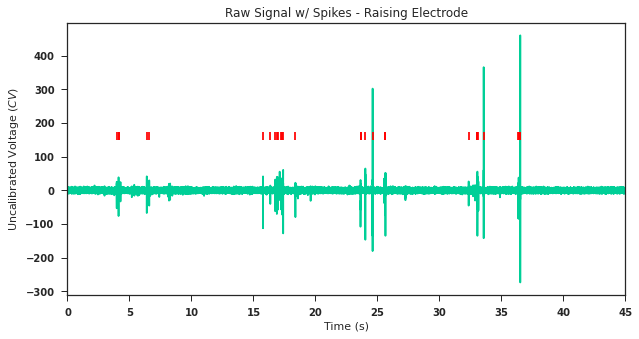

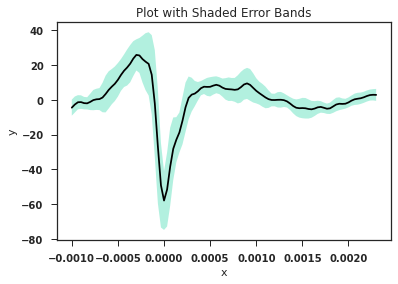

Removed  89 redundant spikes
# spikes detected =  23


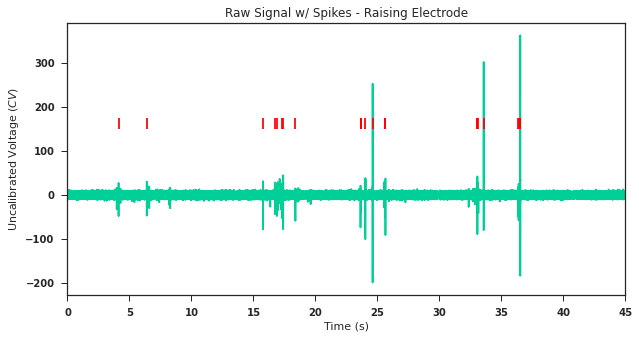

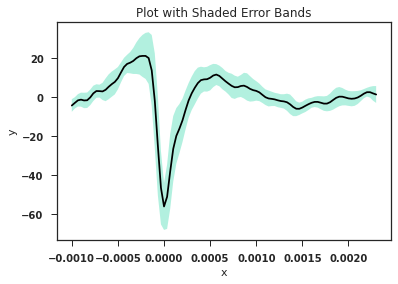

Removed  114 redundant spikes
# spikes detected =  23


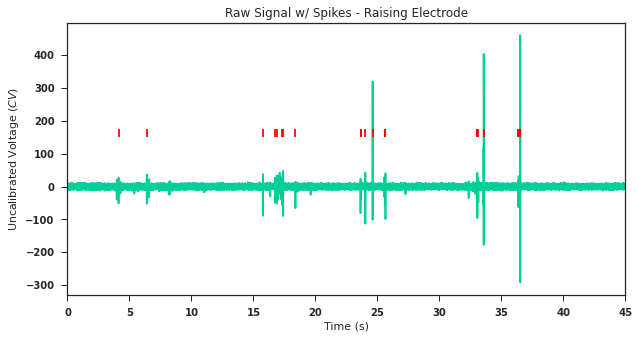

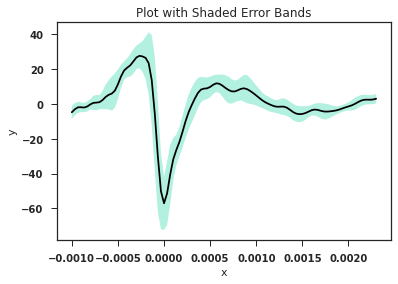

In [521]:
# Time

avg_waveforms = []
std_waveforms = []

for i in range(3):
    time = raise_electrodes[0]
    time = time - np.min(time)

    # Data
    data = raise_electrodes[i+1]
    asa = nel.AnalogSignalArray(data=data,time=time)

    spike_band = [600, 6000]

    spikeband = nel.filtering.sosfiltfilt(asa,fl=spike_band[0],fh=spike_band[1],).data[0] 

    # create spike_times - array [# channels]

    spike_times = []
    threshold = -40

    st, spike_waveforms = detectSpikes(spikeband, time, threshold, fs)
    spike_times.append(st)


    plt.figure(figsize=(10,5))
    # plt.plot(time, data) # plot raw data
    plt.plot(time, spikeband) # plot raw data
    plt.xlabel('Time (s)')
    plt.ylabel(r'Uncalibrated Voltage ($CV$)')
    plt.vlines(time[spike_times],ymin=150,ymax=175,color='r') # plot a vertical line at each detected spike time on the same plot # zoom in a bit
    plt.title("Raw Signal w/ Spikes - Raising Electrode")

    plt.xlim([0, 45])
    # plt.ylim([-150, 200])
    # plt.savefig("file_name")

    plt.show()


    # time_waveforms,np.mean(spike_waveforms, axis=0)
    mean_data = np.mean(spike_waveforms, axis=0)
    std_data = np.std(spike_waveforms, axis=0)
    # Create the plot
    plt.plot(time_waveforms, mean_data, 'k-')
    plt.fill_between(time_waveforms, mean_data - std_data, mean_data + std_data, alpha=0.3)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Plot with Shaded Error Bands')
    plt.show()
    
    avg_waveforms.append(mean_data)
    std_waveforms.append(std_data)


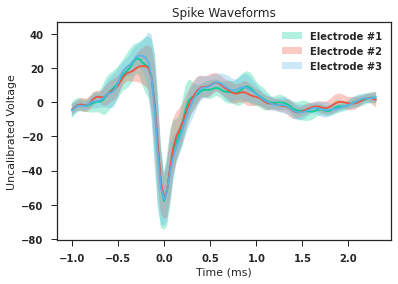

In [558]:
# Data from Raise Electrodes File!!

for i in range(3):    
    plt.plot(time_waveforms*1000, avg_waveforms[i]) #,label="Electrode # "+str(i+1))
    plt.fill_between(time_waveforms*1000, avg_waveforms[i] - std_waveforms[i], avg_waveforms[i] + std_waveforms[i], alpha=0.3, label="Electrode #"+str(i+1))
    
plt.xlabel('Time (ms)')
plt.ylabel('Uncalibrated Voltage')
plt.legend()
plt.title('Spike Waveforms')

# plt.savefig("all_electrodes_waveform.png", dpi=300)
plt.show()


Removed  11 redundant spikes
# spikes detected =  3


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


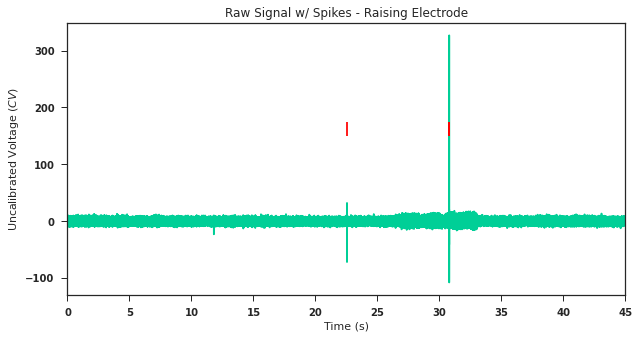

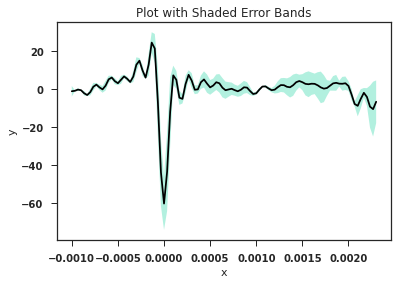

Removed  16 redundant spikes
# spikes detected =  3


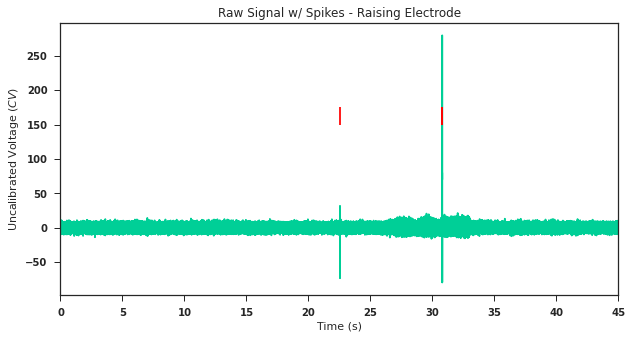

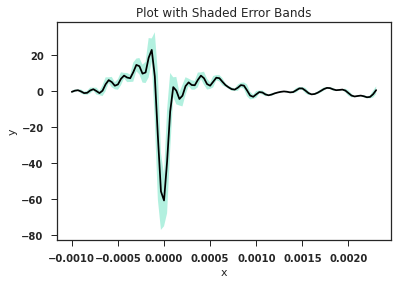

Removed  31 redundant spikes
# spikes detected =  3


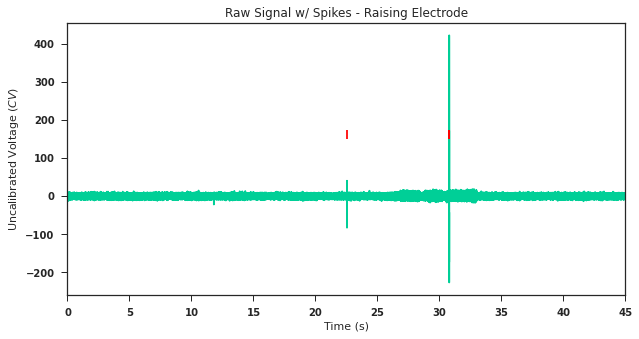

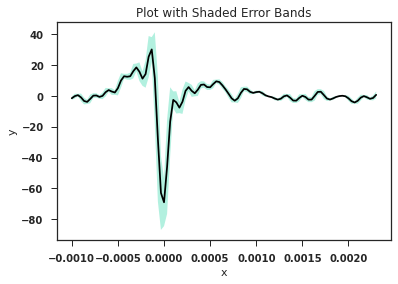

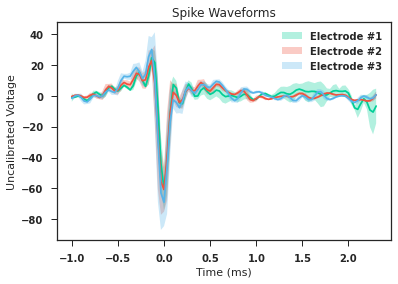

In [559]:
# Time

avg_waveforms = []
std_waveforms = []

for i in range(3):
    time = lfp[0]
    time = time - np.min(time)

    # Data
    data = lfp[i+1]
    asa = nel.AnalogSignalArray(data=data,time=time)

    spike_band = [600, 6000]

    spikeband = nel.filtering.sosfiltfilt(asa,fl=spike_band[0],fh=spike_band[1],).data[0] 

    # create spike_times - array [# channels]

    spike_times = []
    threshold = -40

    st, spike_waveforms = detectSpikes(spikeband, time, threshold, fs)
    spike_times.append(st)


    plt.figure(figsize=(10,5))
    # plt.plot(time, data) # plot raw data
    plt.plot(time, spikeband) # plot raw data
    plt.xlabel('Time (s)')
    plt.ylabel(r'Uncalibrated Voltage ($CV$)')
    plt.vlines(time[spike_times],ymin=150,ymax=175,color='r') # plot a vertical line at each detected spike time on the same plot # zoom in a bit
    plt.title("Raw Signal w/ Spikes - Raising Electrode")

    plt.xlim([0, 45])
    # plt.ylim([-150, 200])
    # plt.savefig("file_name")

    plt.show()


    # time_waveforms,np.mean(spike_waveforms, axis=0)
    mean_data = np.mean(spike_waveforms, axis=0)
    std_data = np.std(spike_waveforms, axis=0)
    # Create the plot
    plt.plot(time_waveforms, mean_data, 'k-')
    plt.fill_between(time_waveforms, mean_data - std_data, mean_data + std_data, alpha=0.3)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Plot with Shaded Error Bands')
    plt.show()
    
    avg_waveforms.append(mean_data)
    std_waveforms.append(std_data)

    
# Data from LFP File!!

for i in range(3):    
    plt.plot(time_waveforms*1000, avg_waveforms[i]) #,label="Electrode # "+str(i+1))
    plt.fill_between(time_waveforms*1000, avg_waveforms[i] - std_waveforms[i], avg_waveforms[i] + std_waveforms[i], alpha=0.3, label="Electrode #"+str(i+1))
    
plt.xlabel('Time (ms)')
plt.ylabel('Uncalibrated Voltage')
plt.legend()
plt.title('Spike Waveforms')

# plt.savefig("all_electrodes_waveform.png", dpi=300)
plt.show()


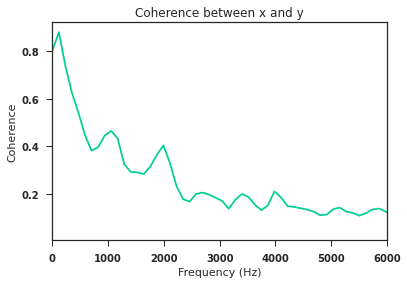

In [560]:
# Compute the coherence
f, Cxy = signal.coherence(raise_electrodes[1], raise_electrodes[2], fs)

# Plot the coherence
plt.plot(f, Cxy)
plt.xlim([-5,6000])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Coherence')
plt.title('Coherence between x and y')
plt.show()

## Plotting only Spike Band Data

In [512]:
# Time
time = raise_electrodes[0]
time = time - np.min(time)

# Data
data = raise_electrodes[1]
asa = nel.AnalogSignalArray(data=data,time=time)

spike_band = [600, 6000]

spikeband = nel.filtering.sosfiltfilt(asa,fl=spike_band[0],fh=spike_band[1],).data[0] 

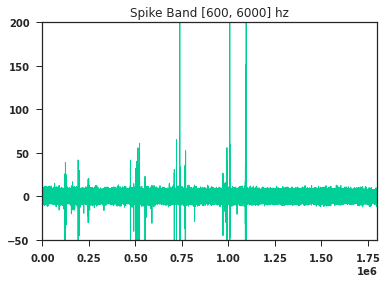

In [513]:
plt.figure()
npl.plot(spikeband, lw=1) 
plt.title('Spike Band ' + str(spike_band) + " hz") 
plt.ylim([-50, 200])
plt.show()

In [514]:
# create spike_times - array [# channels]

spike_times = []
threshold = -40

st, spike_waveforms = detectSpikes(spikeband, time, threshold, fs)
spike_times.append(st)

Removed  140 redundant spikes
# spikes detected =  31


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


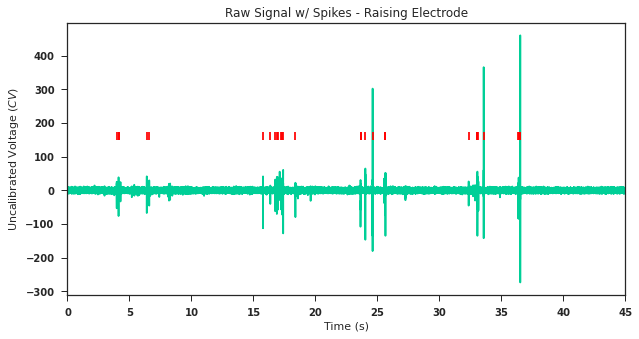

In [519]:
plt.figure(figsize=(10,5))
# plt.plot(time, data) # plot raw data
plt.plot(time, spikeband) # plot raw data
plt.xlabel('Time (s)')
plt.ylabel(r'Uncalibrated Voltage ($CV$)')
plt.vlines(time[spike_times],ymin=150,ymax=175,color='r') # plot a vertical line at each detected spike time on the same plot # zoom in a bit
plt.title("Raw Signal w/ Spikes - Raising Electrode")

plt.xlim([0, 45])
# plt.ylim([-150, 200])
# plt.savefig("file_name")

plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


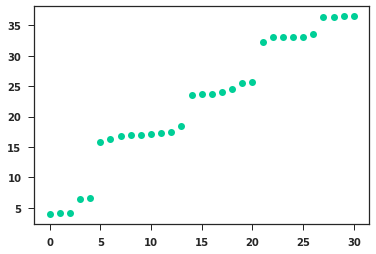

In [496]:
plt.plot(time[spike_times],"o")


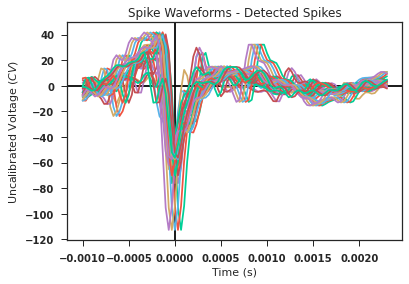

Text(0.5, 1.0, 'Mean Waveform')

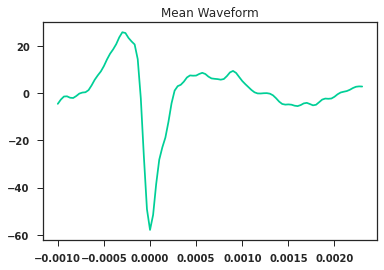

In [490]:
nPlot=len(spike_waveforms)

time_waveforms = np.arange(-30,70,1)/fs # time vector of the waveform in seconds
plt.axvline(0,color="k")
plt.axhline(0,color="k")
plt.plot(time_waveforms,spike_waveforms[:nPlot,:].T)
plt.xlabel('Time (s)')
plt.ylabel(r'Uncalibrated Voltage ($CV$)')
# plt.ylim(-400,550) # keep axis the same across plots for easier comparison
plt.title("Spike Waveforms - Detected Spikes")

plt.savefig("spikes-threshold-")
plt.show()

plt.plot(time_waveforms,np.mean(spike_waveforms, axis=0))
plt.title("Mean Waveform")


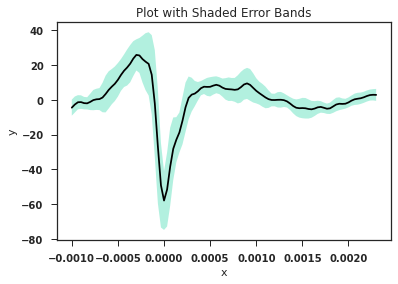

In [491]:
# time_waveforms,np.mean(spike_waveforms, axis=0)
mean_data = np.mean(spike_waveforms, axis=0)
std_data = np.std(spike_waveforms, axis=0)
# Create the plot
plt.plot(time_waveforms, mean_data, 'k-')
plt.fill_between(time_waveforms, mean_data - std_data, mean_data + std_data, alpha=0.3)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot with Shaded Error Bands')
plt.show()

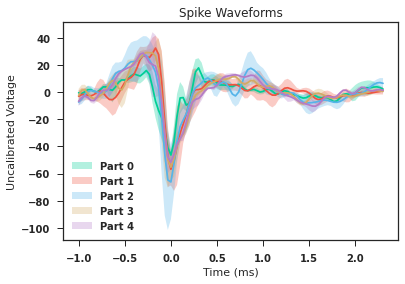

In [506]:
spike_groupings = [(0,4),(5,13),(14,20),(21,26),(27,30)]

for i in range(len(spike_groupings)):
    start_idx, end_idx = spike_groupings[i]
    data = spike_waveforms[start_idx:end_idx]
    mean_data = np.mean(data, axis=0)
    std_data = np.std(data, axis=0)
    
    plt.plot(time_waveforms*1000, mean_data)
    plt.fill_between(time_waveforms*1000, mean_data - std_data, mean_data + std_data, alpha=0.3, label="Part "+str(i))
    
plt.xlabel('Time (ms)')
plt.ylabel('Uncalibrated Voltage')
plt.legend()
plt.title('Spike Waveforms')

plt.save_fig
plt.show()


In [426]:
def asa_plot_waveforms(data_npy, time_npy, spike_threshold=-60, isi=25, filename=None):
    ## Arrange Data
    # Time
    time = time_npy
    print("Data Duration ", time[-1] - time[0], " (s)")

    # Data
    asa = nel.AnalogSignalArray(data=data,time=time)
    spike_band = [600, 6000]
    spikeband = nel.filtering.sosfiltfilt(asa,fl=spike_band[0],fh=spike_band[1],).data[0] 
    lfp = nel.filtering.sosfiltfilt(asa,fl=spike_band[0],fh=spike_band[1],).data[0] 
    
    print("Spike Band Filtered ", spike_band, " Hz")
    
    ## Detect Spikes
    spike_times = []
    st, spike_waveforms = detectSpikes(spikeband, time, spike_threshold, fs, isi)
    spike_times.append(st)
    
    ## Plot Detected Spikes
    plt.figure(figsize=(10,5))
    plt.plot(time, data, label="LFP", color=colors[0]) # plot raw data
    plt.plot(time, spikeband, label="Spikeband", color=colors[1]) # plot raw data
    plt.xlabel('Time (s)')
    plt.ylabel(r'Uncalibrated Voltage ($CV$)')
    plt.vlines(time[spike_times],ymin=np.max(data),ymax=np.max(data)+20,color='blue',label="Spikes") # plot a vertical line at each detected spike time on the same plot # zoom in a bit
    plt.title("LFP w/ Spikes")
    plt.legend()
    plt.show()
    
    ## Plot Wave Forms
    
    nPlot=len(spike_waveforms)
    time_waveforms = np.arange(-30,70,1)/fs # time vector of the waveform in seconds
    plt.axvline(0,color="k")
    plt.axhline(0,color="k")
    plt.plot(time_waveforms,spike_waveforms[:nPlot,:].T)
    plt.xlabel('Time (s)')
    plt.ylabel(r'Uncalibrated Voltage ($CV$)')
#     plt.ylim(np.min(),550) # keep axis the same across plots for easier comparison
    plt.title("Spike Waveforms - Detected " + str(nPlot) + " Spikes")

    if(filename != None):
        plt.savefig(filename)
        
    plt.show()

In [427]:
def time_to_idx(time_array, t1=0, t2=1):
    start_idx = np.where(time_array >= t1)[0][0]
    end_idx = np.where(time_array >= t2)[0][0]
    return np.arange(start_idx, end_idx)

Data Duration  5.999966666666666  (s)
Spike Band Filtered  [600, 6000]  Hz
Removed  96 redundant spikes
# spikes detected =  14


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


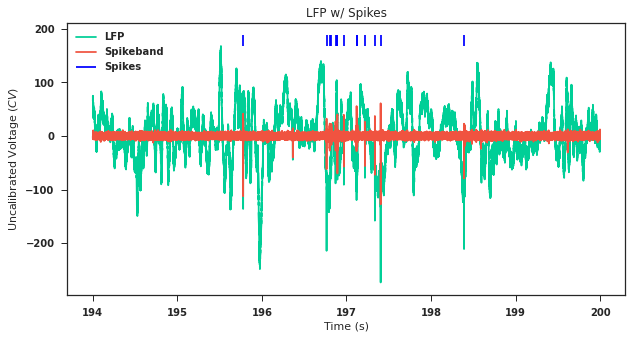

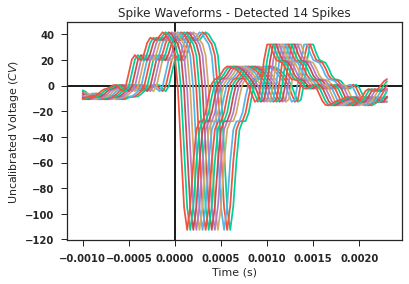

In [435]:
# snip = np.arange(0,20*fs)

time = raise_electrodes[0]
snip = time_to_idx(time, 194, 200)
time = time[snip]
# time = time - np.min(time)
data = raise_electrodes[1][snip]

asa_plot_waveforms(data, time, spike_threshold=20, isi=30, filename="raise_electrodes_time_194-200s")

In [436]:
threshold

100

Removed  1357 redundant spikes
# spikes detected =  126
# of waveforms =  126


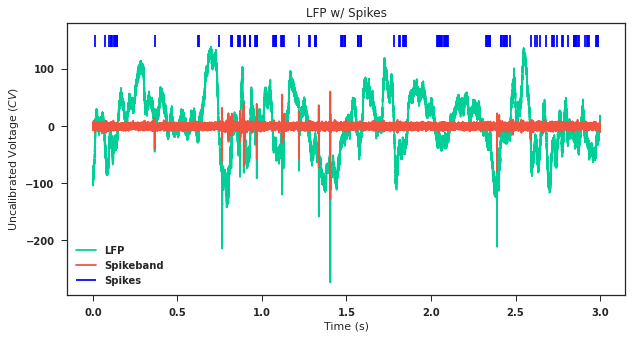

(30,)
(30, 126)


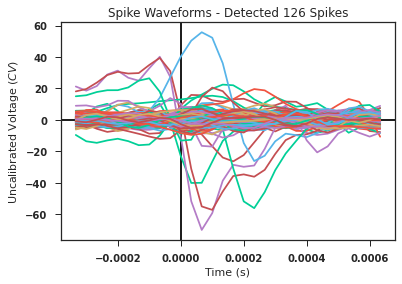

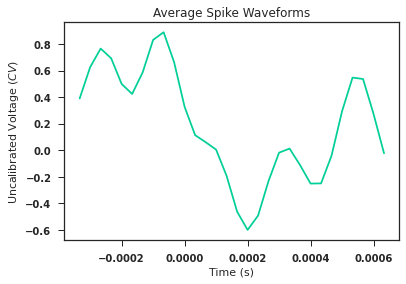

In [557]:
time = raise_electrodes[0]
snip = time_to_idx(time, 196, 199)
time = time[snip]
time = time - np.min(time)
data = raise_electrodes[1][snip]
threshold = -25

asa = nel.AnalogSignalArray(data=data,time=time)
spike_band = [600, 6000]
spikeband = nel.filtering.sosfiltfilt(asa,fl=spike_band[0],fh=spike_band[1],).data[0] 


spike_times = detectSpikeTimes(spikeband, time, threshold, fs, isi=25)

spike_waveforms = extractSpikeWaveforms(spikeband, time, spike_times, points_before=10, points_total=30)

plot_spike_times(time, data, spikeband, spike_times, filename="short_test_spike_times")

plot_waveforms(spike_waveforms, fs, points_before=10, points_total=30, filename="short_test_waveforms")



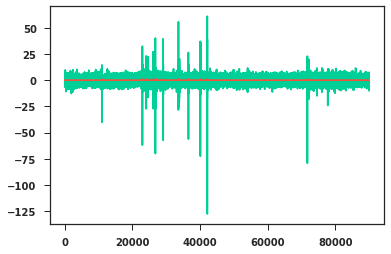

In [471]:
plt.plot(spikeband)
plt.plot(spikeband<-25)


In [461]:
data[spike_times]

# spike_times

array([-90.48 , -50.31 , -50.7  , -50.115, -50.505, -52.845, -55.965,
       -55.185, -51.48 , -51.09 , -65.91 , -54.99 , -51.48 , -70.2  ,
       -52.65 , -51.285, -56.94 , -50.505, -52.845, -51.285, -51.09 ,
       -57.525, -50.505, -51.285, -50.505, -50.115, -61.62 , -51.87 ,
       -51.09 , -50.7  , -50.115, -52.065, -53.04 , -54.405, -58.5  ,
       -53.82 , -53.43 , -50.115, -51.09 , -50.505, -50.115, -50.505,
       -50.115, -50.7  , -52.065, -51.09 , -50.7  , -52.65 , -50.115,
       -50.7  , -50.7  ])

Removed  1695 redundant spikes
# spikes detected =  165
# of waveforms =  165


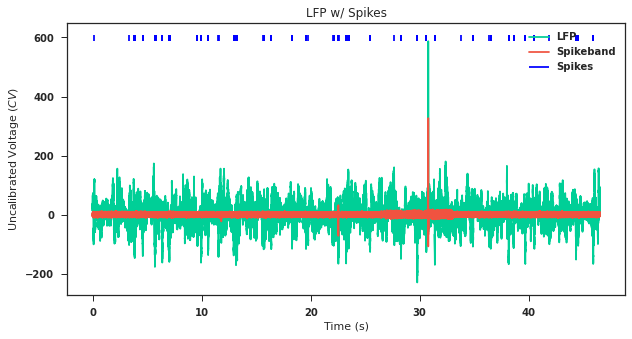

(30,)
(30, 165)


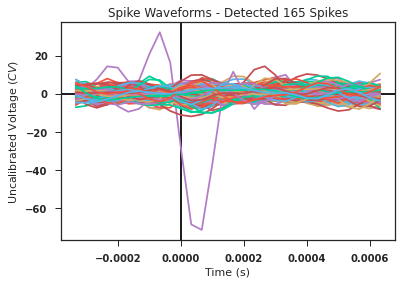

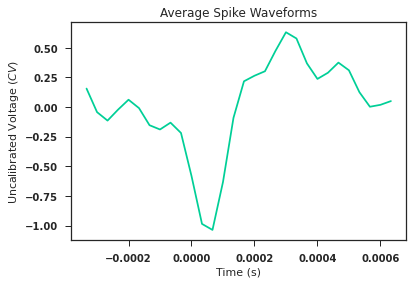

In [473]:
time = lfp[0]
# snip = time_to_idx(time, 130, 200)
# time = time[snip]
time = time - np.min(time)
data = lfp[1] # [snip]
threshold = -100

asa = nel.AnalogSignalArray(data=data,time=time)
spike_band = [600, 6000]
spikeband = nel.filtering.sosfiltfilt(asa,fl=spike_band[0],fh=spike_band[1],).data[0] 


spike_times = detectSpikeTimes(spikeband, time, threshold, fs, isi=25)

spike_waveforms = extractSpikeWaveforms(spikeband, time, spike_times, points_before=10, points_total=30)

plot_spike_times(time, data, spikeband, spike_times, filename="test3_spike_times")

plot_waveforms(spike_waveforms, fs, points_before=10, points_total=30, filename="test3_waveforms")



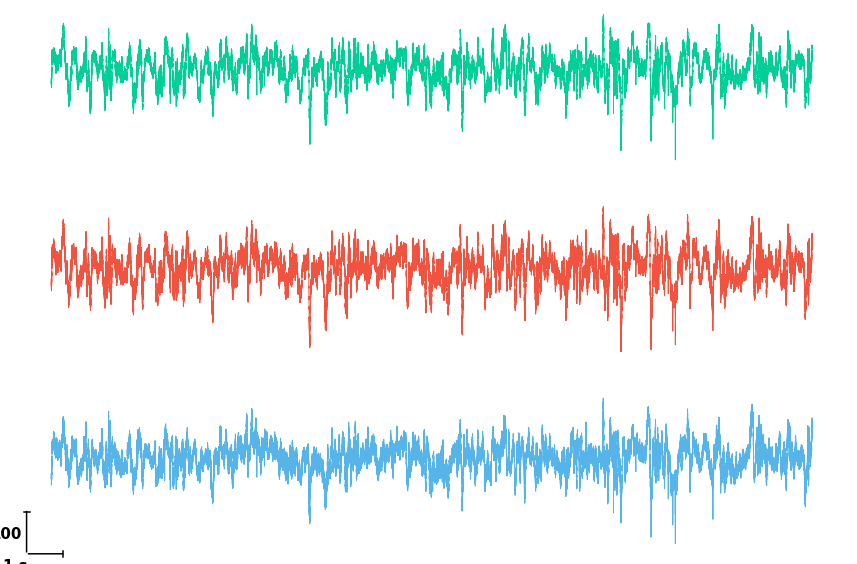

In [572]:
three_electrodes = []
for i in range(3):
    t, snip = make_snippet(time=raise_electrodes[0], data=raise_electrodes[i+1], t_start=181, time_duration=20)
    asa = make_asa(t,data=snip)
    asa = notch_filter(asa)
    three_electrodes.append(asa)
    
n_traces = 3

fig, axes = plt.subplots(n_traces, 1, figsize=(15, 10))
i = 0
for ax in axes:
    plot_data = three_electrodes[i].ydata[0]

    ax.plot(plot_data, color=colors[i],linewidth=1)    
    i += 1
    
npl.utils.clear_left_right(*axes)
npl.utils.clear_top_bottom(*axes)
npl.scalebar.add_scalebar(ax=axes[2], sizex=1*fs, sizey=100, labely='100', labelx='1 s', pad=-2, loc="lower left")


plt.savefig("three-electrodes-raise-electrodes-3-colors.png", dpi=300)

In [568]:
raise_electrodes[0]

array([180.0064    , 180.00643333, 180.00646667, ..., 240.00843333,
       240.00846667, 240.0085    ])